In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import nltk
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.corpora import Dictionary
import time
import spacy
import pyLDAvis.gensim
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/kaggle/input/reviews-a/reviews_playstore_all.csv
/kaggle/input/original-urbanclap/urban.clap.data.csv


In [4]:
data = pd.read_csv('/kaggle/input/original-urbanclap/urban.clap.data.csv')
# data = pd.read_csv('/kaggle/input/original-urbanclap/urban.clap.data.csv')
print(data.shape)
rows_missing_content = data[data['review'].isnull()]
# print(rows_missing_content)
# print(data['content'][238])
# rows_missing_content = data[data['review'].isnull()]
# data = data.dropna(subset=['review'])
# stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

(1554516, 10)


In [5]:
data.head()

,responded_pro_booking,customer_request_id,total_jobs,approval_date,gender,city,rating,review,review_tags,date_of_service
0,59b8c1da2e47a45d00da2ac2,5b0ff9b7bdfde421006f7100,382.0,2017-09-20,female,city_hyderabad_v2,NaN,NaN,NaN,2018-06-01 08:00:00
1,58b01ecabda9ae7979abb694,5b0fea6fcb52792200146cb2,540.0,2017-02-25,female,city_hyderabad_v2,5.0,NaN,NaN,2018-06-01 08:00:00
2,59acfa0fd49d085e0098491f,5b1008cbbdfde421006f7f29,322.0,2017-09-20,female,city_hyderabad_v2,5.0,NaN,Professional's Skill;Punctuality,2018-06-01 08:00:00
3,59478dfadfd82a5d00c352c0,5b0fa21bd418372300836eef,797.0,2018-04-13,female,city_hyderabad_v2,5.0,NaN,NaN,2018-06-01 08:00:00
4,5af9873483ed9e2200f233d1,5b0feb16ce31b9210004e4f5,992.0,2018-05-28,female,city_hyderabad_v2,5.0,She created very friendly atmosphere and did h...,NaN,2018-06-01 08:00:00


In [6]:
def frequent_words(x,n = 30):
    words = ' '.join([str(text) for text in x if isinstance(text, str)])
    c_words = words.split()

    frequency_distribution = FreqDist(c_words)
    words_df = pd.DataFrame({'word':list(frequency_distribution.keys()), 'count':list(frequency_distribution.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = n) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

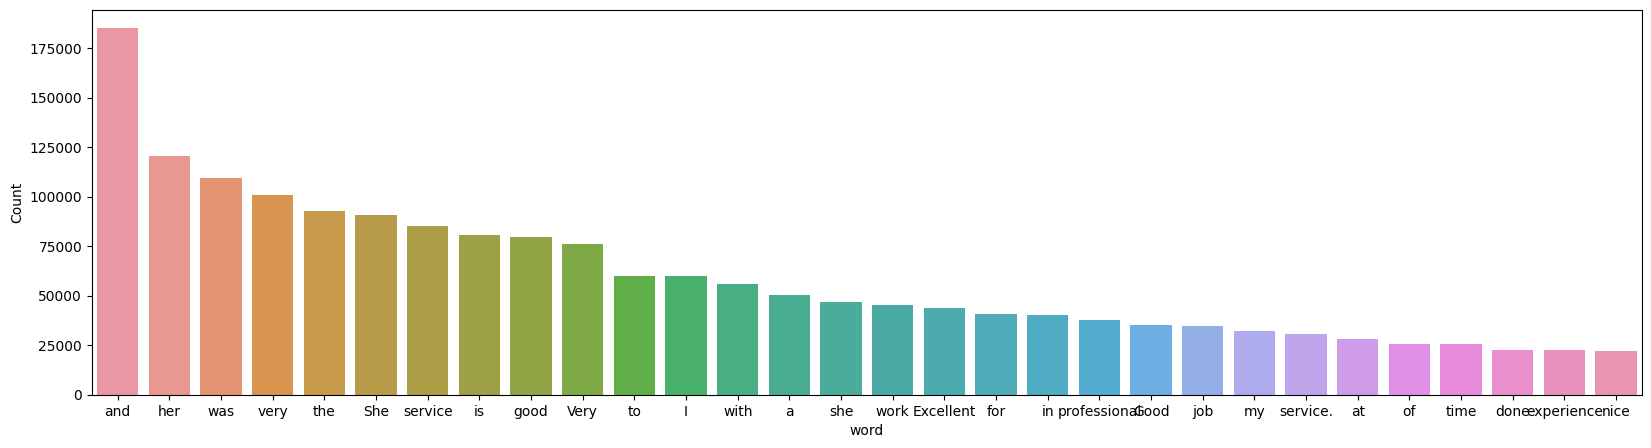

In [8]:
frequent_words(data['review'])

In [6]:
#preprocessing
# for removing punctuations, symbols and other special characters
stop_list =  stop_list = stop_words + ["do", "good", "bad", "nice""awesome", "superb", "excellent", "go", "grt8", "very", "there",
                              "one", "two", "three", "first", "second", "third", "1st", "2nd", "3rd", 
                              "four", "five", "six", "seven", "eight", "nine", "zero", "ten", "twenty", 
                              "hundred", "thousand", "million", "billion", "trillion","nice","service.","service","do","keep"] 
def remove_stopwords(rev):
    rev_words = rev.lower().split()
    rev_new = " ".join([word for word in rev_words if word not in stop_list])
    return rev_new
data['content'] = data['content'].apply(lambda x: str(x))
data['content'] = data['content'].str.replace("[^a-zA-Z#]", " ")

# for removing words less than 2
data['content'] = data['content'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
reviews = []  
for content in data['content']:     #'content'
    content = str(content)
    processed_review = remove_stopwords(content) 
    reviews.append(processed_review)

# make entire text lowercase
reviews = [r.lower() for r in reviews]





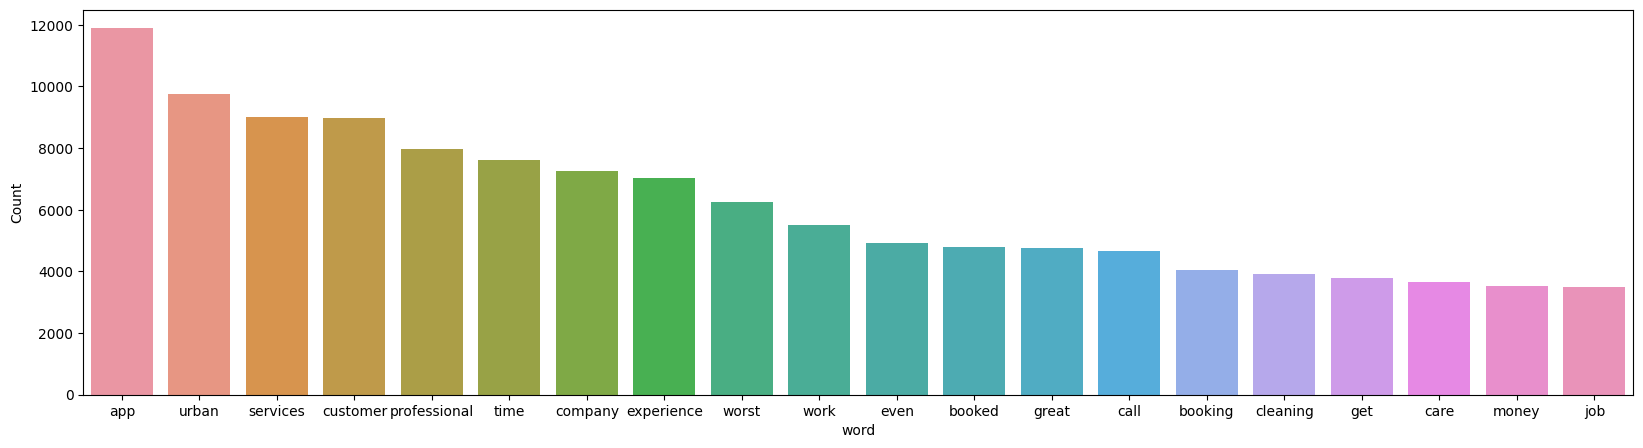

In [7]:
frequent_words(reviews,20)

In [8]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN','VERB']):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [9]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
for word in tokenized_reviews:
    if(word in stop_list):
        tokenized_reviews.remove()  
print(tokenized_reviews[1000])

['maximum', 'professionals', 'mostly', 'salon', 'services', 'punctual.there', 'option', 'sehudule', 'time', '.that', 'useful', 'late']


In [10]:
import gensim
bigram = gensim.models.Phrases(tokenized_reviews, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_reviews], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [11]:
start_time = time.time()
reviews_l = lemmatization(tokenized_reviews)
print(reviews_l[1])
end_time = time.time()
lematization_time = end_time - start_time
print(f"Lemmatization took {lematization_time:.4f} seconds.")


['find', 'phone', 'no', '.', 'call', 'option', 'use', 'option', 'talk', 'customer', 'care', 'use', 'guide', 'requirement', 'lack', 'book', 'service', 'look', 'app', 'find', 'connect', 'customer', 'care', 'app', 'design', 'issue', 'wonder', 'customer', 'talk', 'book', 'service']
Lemmatization took 210.1292 seconds.


In [12]:
import pandas as pd

# Assuming reviews_l is a list of lemmatized reviews
# Example: reviews_l = ["lemmatized review 1", "lemmatized review 2", ...]

# Create a DataFrame with 'content' column
preprocess = []
for i in reviews_l:
    word_string = ' '.join(i) 
    preprocess.append(word_string)
df = pd.DataFrame(preprocess, columns=['content'])

# Specify the file path for the CSV file
csv_file_path = 'lemmatized_reviews.csv'

# Save the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)


In [148]:
csv_file_path = 'lemmatized_reviews.csv'

# Read the CSV file into a new DataFrame
loaded_df = pd.read_csv(csv_file_path)

# Print the head of the loaded DataFrame
print("Head of the Loaded DataFrame:")
print(loaded_df.head())
loaded_df.to_csv("preprocessed.csv")

Head of the Loaded DataFrame:
                                                                                                                                                                                    content
0                                              clarity service tarrif get guy accept pay get tax invoice place ask revise invoice leave response explanation get invoice take do disappoint
1  find phone no . call option use option talk customer care use guide requirement lack book service look app find connect customer care app design issue wonder customer talk book service
2                                                                                  need trying cancel happen app start working partner come cancel force take number take taxis explanation
3                     application become day person show app give option pay option booking want money guarantee get time promise customer support make thing need alternative company lose
4                             

In [13]:
s_time = time.time()
dict = Dictionary(reviews_l)
document_term_matrix = [dict.doc2bow(review) for review in reviews_l]
lda_model = LdaModel(corpus=document_term_matrix, id2word=dict, num_topics=10, random_state=100, chunksize=1000, passes=50)
e_time = time.time()
lda_time = e_time - s_time
print(f"LDA time took {lda_time:.4f} seconds.")

LDA time took 535.0940 seconds.


In [14]:
lda_model.print_topics()

[(0,
  '0.379*"service" + 0.062*"charge" + 0.027*"gr8" + 0.025*"use" + 0.022*"cost" + 0.020*"lot" + 0.018*"market" + 0.018*"price" + 0.017*"become" + 0.015*"base"'),
 (1,
  '0.042*"option" + 0.032*"need" + 0.029*"payment" + 0.026*"try" + 0.021*"add" + 0.021*"make" + 0.021*"aap" + 0.020*"aur" + 0.017*"offer" + 0.016*"find"'),
 (2,
  '0.077*"company" + 0.033*"clap" + 0.029*"need" + 0.027*"guy" + 0.023*"life" + 0.021*"solution" + 0.021*"technician" + 0.021*"take" + 0.019*"place" + 0.018*"bill"'),
 (3,
  '0.087*"gud" + 0.076*"application" + 0.042*"money" + 0.026*"refund" + 0.025*"chor" + 0.024*"balance" + 0.023*"t" + 0.021*"pay" + 0.017*"prompt" + 0.016*"waste"'),
 (4,
  '0.403*"app" + 0.116*"love" + 0.029*"use" + 0.023*"awsome" + 0.019*"user" + 0.012*"area" + 0.009*"machine" + 0.009*"location" + 0.006*"washing" + 0.006*"address"'),
 (5,
  '0.115*"customer" + 0.052*"response" + 0.038*"care" + 0.025*"team" + 0.021*"support" + 0.018*"call" + 0.014*"number" + 0.014*"worker" + 0.013*"contact" 

In [15]:
topics = [
    [(word, float(prob)) for word, prob in re.findall(r'"([^"]*)"\s*\+\s*([0-9.]+)', topic_str)]
    for topic_id, topic_str in lda_model.print_topics()
]
print(topics)

[[('service', 0.062), ('charge', 0.027), ('gr8', 0.025), ('use', 0.022), ('cost', 0.02), ('lot', 0.018), ('market', 0.018), ('price', 0.017), ('become', 0.015)], [('option', 0.032), ('need', 0.029), ('payment', 0.026), ('try', 0.021), ('add', 0.021), ('make', 0.021), ('aap', 0.02), ('aur', 0.017), ('offer', 0.016)], [('company', 0.033), ('clap', 0.029), ('need', 0.027), ('guy', 0.023), ('life', 0.021), ('solution', 0.021), ('technician', 0.021), ('take', 0.019), ('place', 0.018)], [('gud', 0.076), ('application', 0.042), ('money', 0.026), ('refund', 0.025), ('chor', 0.024), ('balance', 0.023), ('t', 0.021), ('pay', 0.017), ('prompt', 0.016)], [('app', 0.116), ('love', 0.029), ('use', 0.023), ('awsome', 0.019), ('user', 0.012), ('area', 0.009), ('machine', 0.009), ('location', 0.006), ('washing', 0.006)], [('customer', 0.052), ('response', 0.038), ('care', 0.025), ('team', 0.021), ('support', 0.018), ('call', 0.014), ('number', 0.014), ('worker', 0.013), ('contact', 0.012)], [('experien

In [1]:
for topic_id, topic_words in enumerate(topics):
    # Sort the words and probabilities in descending order based on probabilities
    sorted_words_probs = sorted(topic_words, key=lambda x: x[1], reverse=True)
    
    # Select the top 5 words and probabilities
    top_words, top_probabilities = zip(*sorted_words_probs[:5])
    
    # Create a bar plot
    plt.figure(figsize=(5, 3))
    plt.barh(top_words, top_probabilities, color='skyblue')
    plt.xlabel('Probability')
    plt.ylabel('Words')
    plt.title(f'Topic {topic_id} Top 5 Words Weights')
    plt.gca().invert_yaxis()
    plt.show()

NameError: name 'topics' is not defined

In [17]:
lda_topic_distributions = []
for doc_bow in document_term_matrix:
    topics = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
    topic_distribution = [topic_prob for topic_id, topic_prob in topics]
    lda_topic_distributions.append(topic_distribution)

In [18]:
print(lda_topic_distributions[1])
print("\n")
print(lda_topic_distributions[2])
print("\n")
print(lda_topic_distributions[3])

[0.14930356, 0.19068313, 0.003127906, 0.036166083, 0.12658648, 0.37077615, 0.03421985, 0.003126716, 0.0031272082, 0.08288292]


[0.07109732, 0.08620318, 0.0059784427, 0.0670684, 0.07101614, 0.07226697, 0.0059766313, 0.08222652, 0.0059781694, 0.5321882]


[0.042302426, 0.14393976, 0.003848577, 0.1847269, 0.04231276, 0.09837073, 0.0038466535, 0.0038469264, 0.05487119, 0.4219341]


In [98]:
LDA_dict_r = {
    'service' : [0,2,6,7,4],
    'platform' : [1,3,5,9,8]
}

In [102]:
lda_service = [sum(lda_topic_distributions[i][idx] for idx in LDA_dict_r['service']) for i in range(len(lda_topic_distributions))]
lda_platform = [sum(lda_topic_distributions[i][idx] for idx in LDA_dict_r['platform']) for i in range(len(lda_topic_distributions))]
# lda_both = [sum(train_vecs_lda[i][idx] for idx in LDA_dict_r['both']) for i in range(len(train_vecs_lda))]

# Add a new column 'lda_category' based on the conditions
for i in range(len(data)):
    if lda_service[i] > 0.5 and lda_platform[i] > 0.5:
        data.at[i, 'lda_category'] = 'both'
    elif lda_service[i] > 0.55:
        data.at[i, 'lda_category'] = 'service'
    elif lda_platform[i] > 0.55:
        data.at[i, 'lda_category'] = 'platform'
    else:
        data.at[i, 'lda_category'] = 'both'

# Save the updated DataFrame back to a CSV file
data.to_csv('data1.csv', index=False)



In [105]:
updated_dataset = pd.read_csv('data1.csv')
service_indices = updated_dataset.index[updated_dataset['lda_category'] == 'service'].tolist()

# Get the indices of rows where lda_category is 'platform'
platform_indices = updated_dataset.index[updated_dataset['lda_category'] == 'platform'].tolist()

# Get the indices of rows where lda_category is 'both'
both_indices = updated_dataset.index[updated_dataset['lda_category'] == 'both'].tolist()

# Print serial numbers (indices) of rows in each category
# print("Serial Numbers of Rows with lda_category 'service':")
# print(service_indices)

# print("\nSerial Numbers of Rows with lda_category 'platform':")
# print(platform_indices)

# print("\nSerial Numbers of Rows with lda_category 'both':")
# print(both_indices)

print(len(service_indices))
print(len(platform_indices))
print(len(both_indices))



37137
25854
44071


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,lda_category
0,f2a7f983-75d9-4c3b-b306-4c4772b5ad5b,Aparna singh,https://play-lh.googleusercontent.com/a/AAcHTt...,There clarity for the services and there tarri...,1,103,7.5.9,04-08-2023 10:20,"Hi Aparna,\nApologies for the less-than-ideal ...",04-08-2023 10:26,7.5.9,service
1,d7f92130-0430-4eb0-8582-aac4c6770abc,Shiv G,https://play-lh.googleusercontent.com/a-/AD_cM...,just can't find your phone no. call back optio...,1,673,7.4.99,01-06-2023 13:08,"Hi Shivesh,\nWe're really sorry that you’re ex...",01-06-2023 13:24,7.4.99,platform
2,f25b2b7b-eaf3-4a3f-9c2d-8aed464aca1d,Shatabhisha Ghosh,https://play-lh.googleusercontent.com/a-/AD_cM...,App does not open when you need open and does ...,1,4,7.5.11,29-08-2023 03:25,"Hi Shatabhisha,\nWe apologize for the inconven...",29-08-2023 03:38,7.5.11,platform
3,78dab723-dc59-4f21-8ffb-723d6b1fedb3,Madhurjya Baruah,https://play-lh.googleusercontent.com/a-/AD_cM...,The application becoming more and more unusabl...,2,13,7.5.10,15-08-2023 14:49,"Hi Madhurjya,\nApologies for the less-than-ide...",15-08-2023 14:58,7.5.10,platform
4,af1a9654-77ae-4bb9-8977-37e13b5d408f,Navlyn Anna,https://play-lh.googleusercontent.com/a-/AD_cM...,Pretty good app but was hard use the starting....,4,4,7.5.11,25-08-2023 23:45,"Hi Navlyn,\nWe have taken your feedback and it...",26-08-2023 01:20,7.5.11,service


In [127]:
original_dataset = pd.read_csv('data1.csv')

# Select only the 'content' and 'lda_category' columns
selected_columns = ['content', 'lda_category']
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', None)
updated_dataset.head()
# print(updated_dataset)

,content,lda_category
0,"There clarity for the services and there tarrifs. You opt for service you get quote from the service guy that you accept pay. When you get the tax invoice, different from the one you accepted first place. Then you ask for revised correct invoice, you are left with vague responses and explanations. can't even get the correct invoice the service taken from UC. Not done. Disappointed!!",service
1,"just can't find your phone no. call back option. There used option talk customer care where someone used guide requirements. Due lack that not able book your services. looked everywhere the app but just can't find how connect customer care, It's annoying.. not sure it's app design issue intentionally they did it. intentional can only wonder why customer can't talk you how they will able book services !!!",platform
2,App does not open when you need open and does slow...horrible have been trying cancel booking but does not happen and the app starts working just when the partner about come and then you cannot cancel and forced take the service. Pathetic The more number service you take higher are the taxes without explanation,platform
3,"The application becoming more and more unusable now days. Their service persons doesn't show up, the app not give the option for pay online after service option while booking any service. they want the money upfront, but without any guarantee that you will get the service time promised! Moreover, their non-existent customer support making the thing worse overall. need alternative now. Urban company has lost completely.",platform
4,Pretty good app but was hard use the starting. find difficult understand the app because things are bit complicated and have around asking people help me. Other than this think that the services provided are really good along with the people course. Love Urban Company. Keep the hard work!!!,service


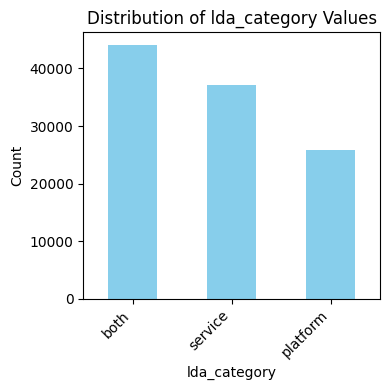

In [141]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have loaded your original dataset into 'original_dataset'

# Select only the 'content' and 'lda_category' columns
selected_columns = ['content', 'lda_category']
updated_dataset = original_dataset[selected_columns]

# Count the occurrences of each unique value in 'lda_category'
lda_category_counts = updated_dataset['lda_category'].value_counts()

# Plot the distribution using a bar chart
plt.figure(figsize=(4,4))
lda_category_counts.plot(kind='bar', color='skyblue')
plt.xlabel('lda_category')
plt.ylabel('Count')
plt.title('Distribution of lda_category Values')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


In [128]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews_l, dictionary=dict, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.5567079060930837


In [137]:
import numpy as np
from sklearn.cluster import KMeans

# Assuming you have your feature vectors stored in a numpy array called 'feature_vectors'
# Each row of 'feature_vectors' corresponds to the feature vector of a record

# Define the number of clusters (2 clusters: service specific and platform specific)
num_clusters = 2

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(lda_topic_distributions)
service_specific_cluster_label = 0 
platform_specific_cluster_label = 1

updated_dataset_kmeans = pd.read_csv('data1.csv')

for i in range(len(cluster_labels)):
    if cluster_labels[i] == service_specific_cluster_label:
        updated_dataset_kmeans['lda_category'] == 'service'
    elif cluster_labels[i] == platform_specific_cluster_label:
        updated_dataset_kmeans['lda_category'] == 'platform'

# Now, 'service_specific_records' contains indices of records classified as service specific,
# and 'platform_specific_records' contains indices of records classified as platform specific.

# Print or use the classified records as needed
# print("Service Specific Records: ", service_specific_records)
# print("Platform Specific Records: ", platform_specific_records)


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KeyboardInterrupt: 

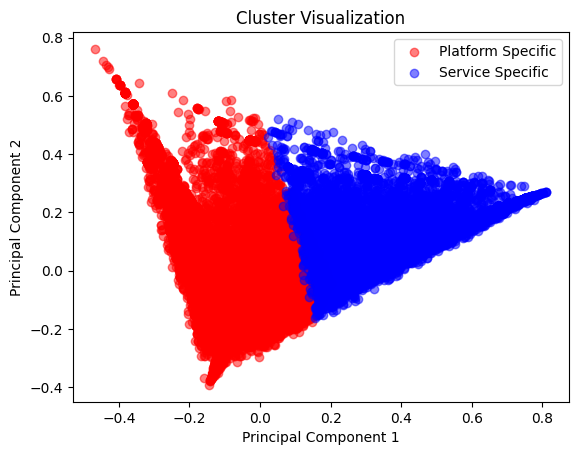

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming cluster_labels, lda_topic_distributions are defined as in your previous code
# num_clusters = 2

# Apply PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2, random_state=42)
reduced_features = pca.fit_transform(lda_topic_distributions)

# Define colors for the clusters
colors = ['red', 'blue']

# Define cluster names
cluster_names = ['Platform Specific', 'Service Specific']

# Visualize the clusters
for i in range(num_clusters):
    cluster_indices = np.where(cluster_labels == i)
    plt.scatter(reduced_features[cluster_indices, 0], reduced_features[cluster_indices, 1],
                label=cluster_names[i], color=colors[i], alpha=0.5)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Visualization')
plt.legend()
plt.show()


In [130]:
print(service_specific_records[1:100])

[1, 4, 5, 7, 8, 10, 11, 13, 15, 18, 19, 20, 21, 22, 23, 24, 26, 28, 29, 32, 33, 35, 37, 38, 39, 41, 42, 43, 44, 46, 47, 48, 49, 51, 53, 54, 55, 57, 60, 61, 62, 64, 69, 70, 71, 75, 76, 77, 78, 81, 82, 83, 84, 87, 89, 90, 93, 94, 96, 97, 98, 100, 101, 102, 103, 107, 108, 111, 112, 113, 115, 116, 117, 118, 119, 120, 121, 123, 124, 125, 128, 129, 131, 134, 135, 136, 138, 140, 141, 142, 144, 145, 146, 147, 149, 150, 154, 155, 156]


In [131]:
print(platform_specific_records[1:100])

[3, 6, 9, 12, 14, 16, 17, 25, 27, 30, 31, 34, 36, 40, 45, 50, 52, 56, 58, 59, 63, 65, 66, 67, 68, 72, 73, 74, 79, 80, 85, 86, 88, 91, 92, 95, 99, 104, 105, 106, 109, 110, 114, 122, 126, 127, 130, 132, 133, 137, 139, 143, 148, 151, 152, 153, 158, 159, 167, 169, 170, 171, 173, 176, 178, 180, 181, 184, 186, 188, 189, 200, 205, 206, 210, 212, 213, 217, 221, 227, 229, 231, 232, 233, 239, 240, 243, 244, 246, 249, 255, 258, 260, 263, 264, 265, 266, 275, 277]
